In [1]:
import numpy as np
import torch
# Base directory containing images and mask data
BASE_DIR = r"D:\understanding_cloud_organization"
torch.cuda.empty_cache()

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch

# Multi-class augmentation
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(translate_percent=(0.1, 0.1), scale=(0.9, 1.1), rotate=(-20, 20), p=0.5),  # Corrected Affine
    A.ElasticTransform(p=0.2, alpha=1, sigma=50),  # Removed alpha_affine
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Adjusted for 3 channels
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Adjusted for 3 channels
    ToTensorV2()
])

def load_image_mask(image_path, mask_path, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load multi-class mask
    mask = torch.tensor(mask, dtype=torch.long)  # Convert to tensor
    height, width = 256, 256  # Or any other fixed size
    image = cv2.resize(image, (width, height))
    mask = cv2.resize(mask.numpy(), (width, height), interpolation=cv2.INTER_NEAREST)

    augmented = transform(image=image, mask=mask)  # Apply augmentation
    return augmented["image"], augmented["mask"]

In [3]:
import torch
import os
from torch.utils.data import Dataset, DataLoader

class CloudDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))
        if not os.path.exists(mask_path):
            raise ValueError(f"Mask file not found: {mask_path}")

        image, mask = load_image_mask(img_path, mask_path, self.transform)
        return image, mask

# Create datasets
train_dataset = CloudDataset(
    image_dir=os.path.join(BASE_DIR, "train", "images"),
    mask_dir=os.path.join(BASE_DIR, "train", "masks"),
    transform=train_transform
)

val_dataset = CloudDataset(
    image_dir=os.path.join(BASE_DIR, "val", "images"),
    mask_dir=os.path.join(BASE_DIR, "val", "masks"),
    transform=val_transform
)

test_dataset = CloudDataset(
    image_dir=os.path.join(BASE_DIR, "test", "images"),
    mask_dir=os.path.join(BASE_DIR, "test", "masks"),
    transform=val_transform
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

print("Multi-class DataLoaders are ready!")

Multi-class DataLoaders are ready!


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=5):  # 5 classes (background + 4 cloud types)
        super(UNet, self).__init__()

        self.encoder = models.resnet34(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layer

        self.conv_up = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(256, out_channels, kernel_size=1)  # 5 output channels

    def forward(self, x):
        x = self.encoder(x)
        x = self.upsample(F.relu(self.conv_up(x)))
        x = self.final_conv(x)
        return x  # No sigmoid for multi-class segmentation

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print("Multi-class model ready!")

Multi-class model ready!


In [5]:
model.load_state_dict(torch.load(r"D:\understanding_cloud_organization\best_model.pth"))
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\ariad\AppData\Local\Temp\ipykernel_12580\93660681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"D:\understanding_cloud_orga

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def dice_coefficient(preds, labels, num_classes=5, smooth=1e-6):
    dice = 0.0
    for c in range(num_classes):
        # Binarize the masks
        pred_c = (preds == c).float()
        label_c = (labels == c).float()

        intersection = (pred_c * label_c).sum()
        union = pred_c.sum() + label_c.sum()

        dice += (2. * intersection + smooth) / (union + smooth)

    return dice / num_classes  # Average over classes
model.eval()

def test_model(model, test_loader):
    running_test_loss = 0.0
    correct, total = 0, 0
    running_dice = 0.0

    criterion = nn.CrossEntropyLoss()  # Same loss function used during training

    with torch.no_grad():
        progress_bar_test = tqdm(test_loader, desc="Testing", leave=True)
        for images, masks in progress_bar_test:
            images, masks = images.to(device), masks.to(device).long()

            outputs = model(images)
            outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
            loss = criterion(outputs_resized, masks)

            running_test_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(outputs_resized, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Compute Dice Coefficient
            dice = dice_coefficient(preds, masks, num_classes=5)
            running_dice += dice

            progress_bar_test.set_postfix(loss=loss.item())

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct / total * 100
    avg_dice_score = running_dice / len(test_loader)  # Average Dice score over the test set

    print("\nTest Results:")
    print(f"  ➤ Test Loss: {avg_test_loss:.4f}")
    print(f"  ➤ Test Accuracy: {test_accuracy:.2f}%")
    print(f"  ➤ Test Dice Score: {avg_dice_score:.4f}")

# Run the test function
test_model(model, test_loader)


Testing: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it, loss=0.785]


Test Results:
  ➤ Test Loss: 0.8552
  ➤ Test Accuracy: 66.09%
  ➤ Test Dice Score: 0.5946


In [7]:
import matplotlib.pyplot as plt

# Define class colors (R, G, B)
class_colors = {
    0: (0, 0, 0),       # Background -> Black
    1: (255, 0, 0),     # Fish -> Red
    2: (0, 255, 0),     # Flower -> Green
    3: (0, 0, 255),     # Gravel -> Blue
    4: (255, 255, 0)    # Sugar -> Yellow
}

def apply_color_mask(mask):
    """
    Converts a single-channel mask into a 3-channel colored image.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls, color in class_colors.items():
        color_mask[mask == cls] = color  # Apply color per class

    return color_mask

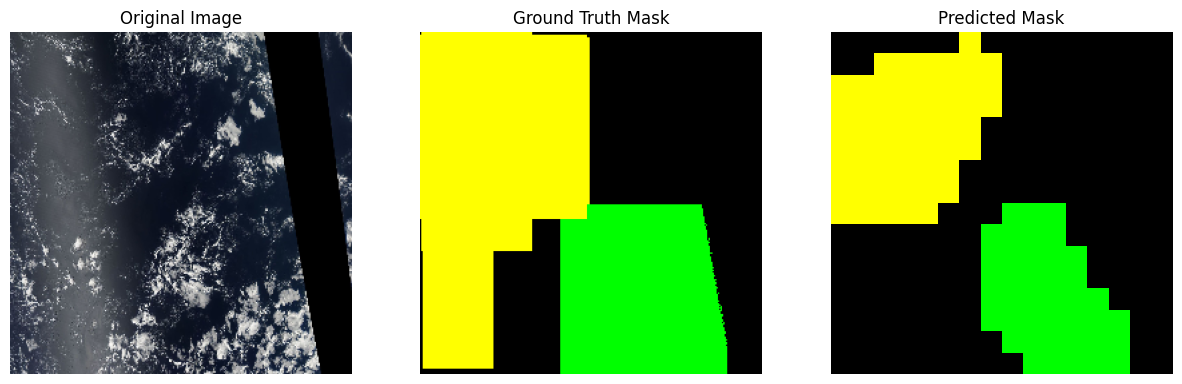

In [14]:
import random

def visualize_predictions(model, dataset):
    model.eval()
    
    idx = random.randint(0, len(dataset) - 1)  # Random sample
    image, mask = dataset[idx]
    image = image.to(device).unsqueeze(0)  # Add batch dim

    with torch.no_grad():
        output = model(image)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Get predicted class

    # Convert masks to colored images
    true_mask_colored = apply_color_mask(mask.numpy())
    pred_mask_colored = apply_color_mask(pred_mask)

    # Convert image back to [0,1] range for display
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize

    # Plot images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(true_mask_colored)
    ax[1].set_title("Ground Truth Mask")
    ax[2].imshow(pred_mask_colored)
    ax[2].set_title("Predicted Mask")
    
    for a in ax:
        a.axis("off")
    
    plt.show()

# Visualize a sample
visualize_predictions(model, test_dataset)